<a href="https://colab.research.google.com/github/davoodwadi/davoodwadi.github.io/blob/main/Session_7_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Classic libraries
import pandas as pd
import numpy as np

# Data science libraries
import sklearn as sk
from sklearn.cluster import KMeans   # KMeans function
from sklearn.datasets import make_circles, make_blobs  # Datasets
from sklearn.model_selection import train_test_split   # Cross validation library
from sklearn import mixture

# Data visualization libaries
import matplotlib.pyplot as plt
# A must! For nice an easy figures - look for sns command in the notebook
import seaborn as sns
from matplotlib.pyplot import cm   # This is a nice color chart

%matplotlib inline

# Code to obtain utilities.py
!wget -nc https://raw.githubusercontent.com/lcharlin/80-629/master/week7-Unsupervised/utilities.py
!mkdir Images
!wget -nc -P Images https://raw.githubusercontent.com/lcharlin/80-629/master/week7-Unsupervised/Images/AE.png

# Homemade libraries
from utilities import color, super_scat_it, distance, initiate, estimate_centroid

--2023-10-17 19:50:19--  https://raw.githubusercontent.com/lcharlin/80-629/master/week7-Unsupervised/utilities.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4292 (4.2K) [text/plain]
Saving to: ‘utilities.py’

utilities.py        100%[===================>]   4.19K  --.-KB/s    in 0s      

2023-10-17 19:50:19 (23.1 MB/s) - ‘utilities.py’ saved [4292/4292]

--2023-10-17 19:50:19--  https://raw.githubusercontent.com/lcharlin/80-629/master/week7-Unsupervised/Images/AE.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55744 (54K

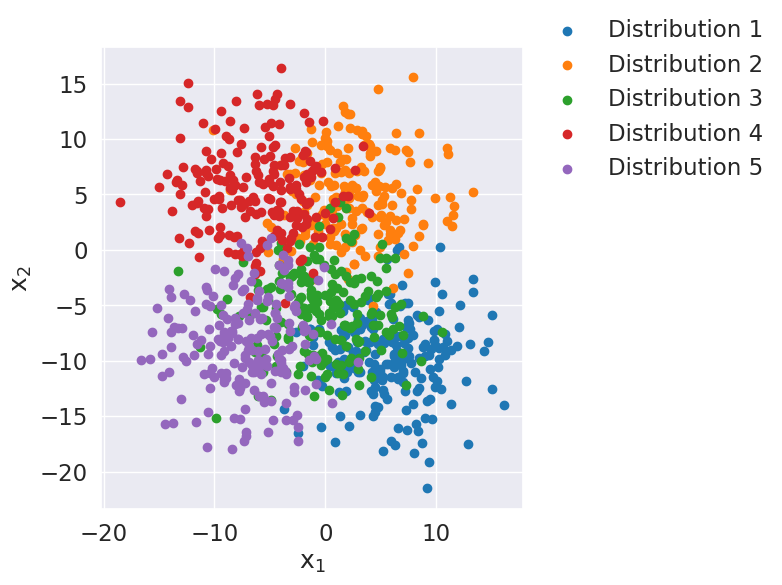

In [ ]:
nb_obs = 1000   # Number of observation
k = 5   # Number of clusters

# try 4 and 1
std = 4   # Standard deviation associated to the isotopic Gaussian Mixture -
dim = 2   # Covariates dimension - if dim > 2, don't expect data vizualisation from matplotlib!
seed = 10   # Random seed to replicate the experience

# Data generation
X, y = make_blobs(n_samples=nb_obs, centers=k, cluster_std=std,
                  n_features=dim, random_state=seed)

# Data visualization - see utilities.py script
super_scat_it(X, y, k)

Step 1: init centroids

In [ ]:
k = 3
centroid = np.array([
    [0, 0],
    [10,10],
    [-10, -10]
])
centroid

array([[  0,   0],
       [ 10,  10],
       [-10, -10]])

In [ ]:
X.shape

(1000, 2)

In [ ]:
distList=[]
for i in range(k):
  dist = ((X - centroid[i])**2).sum(-1)
  print(dist.shape)
  distList.append(dist)
dists = np.stack(distList, axis = -1)
dists.shape

(1000,)
(1000,)
(1000,)


(1000, 3)

In [ ]:
dists[0]

array([119.86211768, 427.46909266, 212.25514271])

In [ ]:
np.argmin([0,0,1])

0

In [ ]:
label = np.argmin(dists, axis = -1)

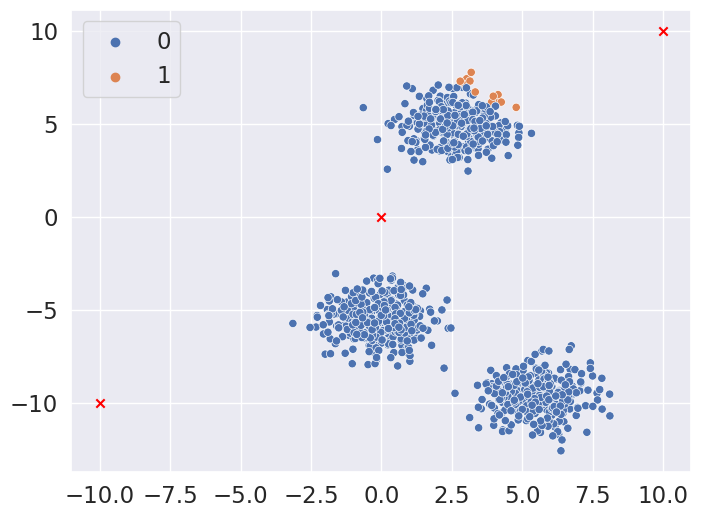

In [ ]:
import seaborn as sns

ax = sns.scatterplot(x = X[:, 0], y = X[:, 1], hue=label)
ax.scatter(centroid[:, 0], centroid[:, 1], color='red', marker='x')

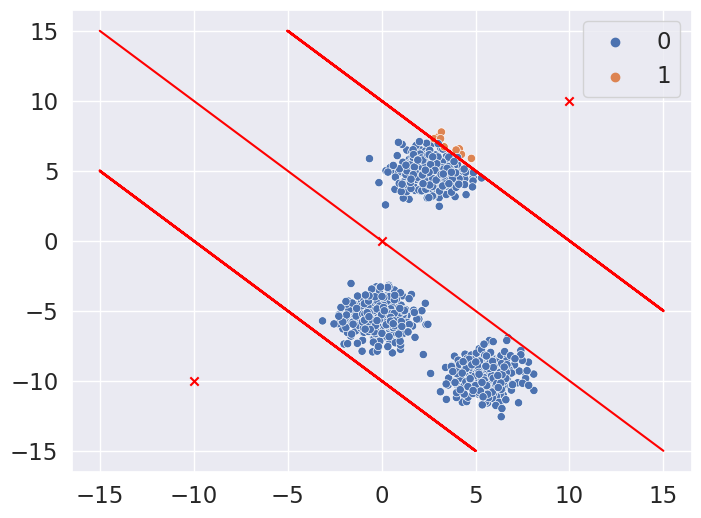

In [ ]:
x1 = np.linspace(-15, 15, num=1000)
x2 = np.linspace(-15, 15, num=1000)
x1_mesh, x2_mesh = np.meshgrid(x1, x2)
x1_mesh = x1_mesh.ravel()
x2_mesh = x2_mesh.ravel()
x_mesh = np.stack([x1_mesh, x2_mesh], axis =-1)

tol = 1
dist_c0 = ((x_mesh-centroid[0])**2).sum(-1)
dist_c1 = ((x_mesh-centroid[1])**2).sum(-1)
dist_c2 = ((x_mesh-centroid[2])**2).sum(-1)

equidistance_01 = np.where(np.abs(dist_c0 - dist_c1)<tol)[0]
equidistance_02 = np.where(np.abs(dist_c0 - dist_c2)<tol)[0]
equidistance_12 = np.where(np.abs(dist_c1 - dist_c2)<tol)[0]
ax = sns.scatterplot(x=X[:,0], y=X[:,1], hue=label)
ax.scatter(centroid[:,0], centroid[:,1], marker='x', color='red')
ax.plot(x_mesh[equidistance_01][:,0], x_mesh[equidistance_01][:,1], color='red')
ax.plot(x_mesh[equidistance_02][:,0], x_mesh[equidistance_02][:,1], color='red')
ax.plot(x_mesh[equidistance_12][:,0], x_mesh[equidistance_12][:,1], color='red')


In [ ]:
def plot_kmeans(X, label, centroid):
  x1 = np.linspace(-15,15, num=2000)
  x2 = np.linspace(-20,15, num=2000)
  x1_mesh, x2_mesh = np.meshgrid(x1,x2)

  x1_mesh = x1_mesh.ravel()
  x2_mesh = x2_mesh.ravel()
  x_mesh = np.stack([x1_mesh, x2_mesh], axis=-1)
  tol = 1.

  ax = sns.scatterplot(x=X[:,0], y=X[:,1], hue=label)
  ax.scatter(centroid[:,0], centroid[:,1], marker='x', color='red')


  distList = []
  for i in range(k):
    # c0 = centroid[0]
    # c1 = centroid[1]
    # c2 = centroid[2]
    dist_c = ((x_mesh-centroid[i])**2).sum(-1)
    distList.append(dist_c)
    # dist_c1 = ((x_mesh-c1)**2).sum(-1)
    # dist_c2 = ((x_mesh-c2)**2).sum(-1)
  for i in range(k):
    for j in range(i+1, k):
      equidistance_idx = np.where(np.abs(distList[i] - distList[j])<tol)[0]
      print(f'index: {equidistance_idx}')
      ax.plot(x_mesh[equidistance_idx][:,0], x_mesh[equidistance_idx][:,1], color='red')
  return ax

In [ ]:
# step 1: update centroids
X[label==0].mean(0)

array([ 2.66390984, -3.51057107])

### kmeans update

In [ ]:
k = 1000
centroid = np.random.choice(X.shape[0], k)
centroid = X[centroid]
centroid

array([[11.64043071,  3.99012917],
       [ 2.23747052, 12.25920027],
       [ 6.24985027, -5.18995183],
       ...,
       [-1.65120925, -2.63691358],
       [ 4.34142091, -7.13214427],
       [-1.78339836, -7.17532697]])

In [ ]:
distList=[]
for i in range(k):
  dist = ((X - centroid[i])**2).sum(-1)
  print(dist.shape)
  distList.append(dist)
dists = np.stack(distList, axis = -1)
label = np.argmin(dists, axis=-1)
# label

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


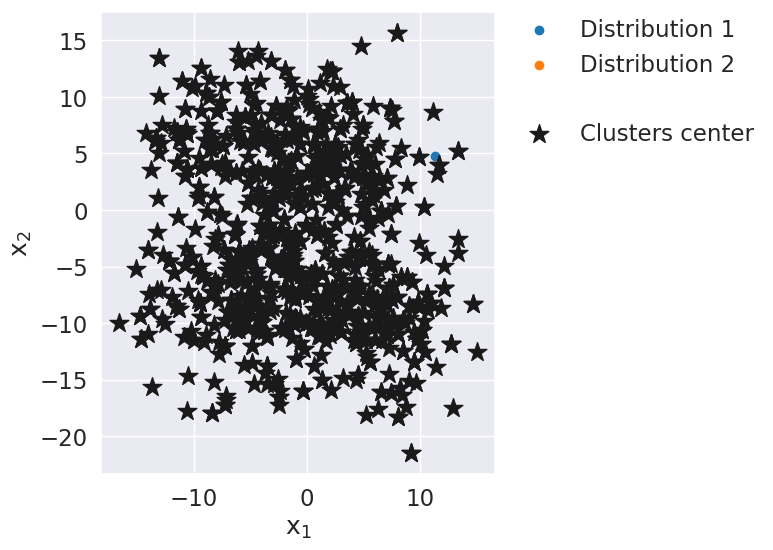

In [ ]:
super_scat_it(X, label, 2, centroid)

KeyboardInterrupt: ignored

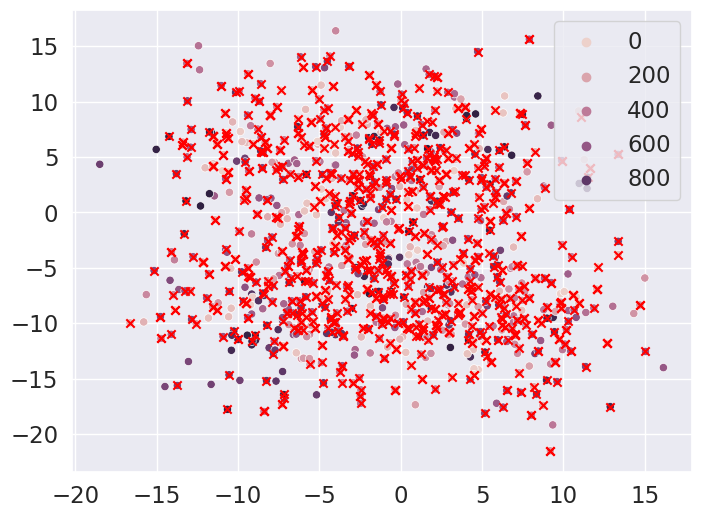

In [ ]:
plot_kmeans(X,label,centroid)

In [ ]:
# Step1: estimate new centroids
for i in range(k):
  centroid_points = X[label==i]
  new_estimate_c = centroid_points.mean(axis=0)
  if np.any(np.isnan(new_estimate_c)):
    print(f'empty cluster: {i}')
    continue
  centroid[i,:] = new_estimate_c
# plot_kmeans(X,label,centroid)

<ipython-input-86-78acfc7eb698>:4: RuntimeWarning: Mean of empty slice.
  new_estimate_c = centroid_points.mean(axis=0)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


empty cluster: 49
empty cluster: 58
empty cluster: 67
empty cluster: 75
empty cluster: 97
empty cluster: 100
empty cluster: 105
empty cluster: 131
empty cluster: 138
empty cluster: 143
empty cluster: 150
empty cluster: 153
empty cluster: 156
empty cluster: 162
empty cluster: 167
empty cluster: 175
empty cluster: 196
empty cluster: 200
empty cluster: 207
empty cluster: 214
empty cluster: 219
empty cluster: 223
empty cluster: 248
empty cluster: 258
empty cluster: 259
empty cluster: 268
empty cluster: 277
empty cluster: 279
empty cluster: 283
empty cluster: 288
empty cluster: 291
empty cluster: 292
empty cluster: 293
empty cluster: 304
empty cluster: 308
empty cluster: 309
empty cluster: 311
empty cluster: 312
empty cluster: 315
empty cluster: 319
empty cluster: 323
empty cluster: 330
empty cluster: 335
empty cluster: 339
empty cluster: 341
empty cluster: 343
empty cluster: 348
empty cluster: 349
empty cluster: 352
empty cluster: 353
empty cluster: 357
empty cluster: 360
empty cluster: 36

In [ ]:
# step 2: update responsibilties
distList=[]
for i in range(k):
  dist = ((X - centroid[i])**2).sum(-1)
  distList.append(dist)
dists = np.stack(distList, axis=-1)

old_label = label

label = np.argmin(dists, axis=-1)
if np.all(label==old_label):
  print('converged')
else:
  print(f'{(label != old_label).sum()} points changed clusters')
# plot_kmeans(X, label, centroid)

152 points changed clusters


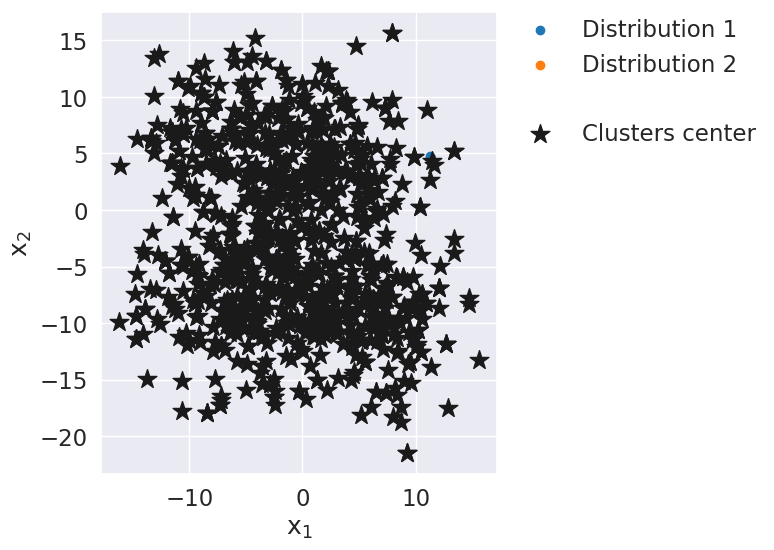

In [ ]:
super_scat_it(X, label, 2, centroid)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test = train_test_split(X, test_size=0.2)
X_test, X_valid = train_test_split(X_test, test_size=0.5)
X_train.shape, X_valid.shape, X_test.shape

((800, 2), (100, 2), (100, 2))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


index: [1553998 1553999 1555994 ... 2512001 2512002 2512003]
index: [1058000 1058001 1060000 ... 3009999 3011998 3011999]
index: [    958     959     960 ... 3999035 3999036 3999037]


<Axes: >

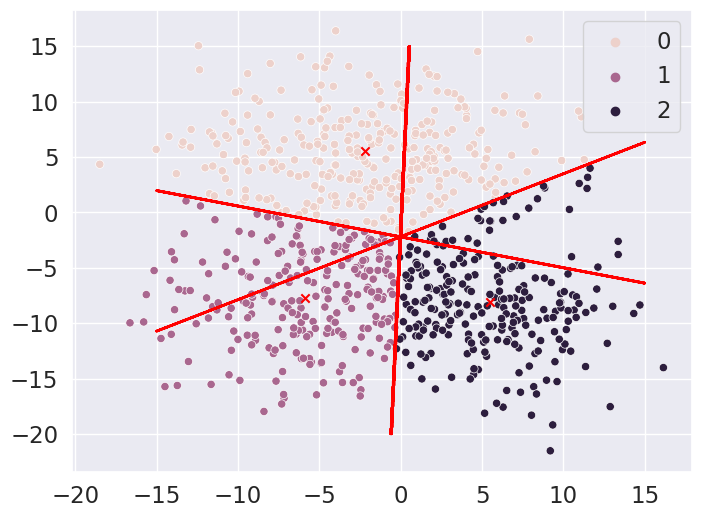

In [ ]:
k = 3
km = KMeans(k)
km.fit(X_train)
plot_kmeans(X_train, km.labels_, km.cluster_centers_)

In [ ]:
np.mean(np.min(distance(X_train, km.cluster_centers_), axis=1))

19.12240266172254

In [ ]:
np.mean(np.min(distance(X_valid, km.cluster_centers_), axis=1))

18.6988932263249

In [ ]:
msdList=[]
ssList=[]
for k in range(2, 50):
  km = KMeans(k)
  km.fit(X_train)
  MSD_valid = np.mean(np.min(distance(X_valid, km.cluster_centers_), axis=1))
  ss = silhouette_score(X_valid, km.predict(X_valid))
  msdList.append(MSD_valid)
  ssList.append(ss)
  # plot_kmeans(X_train, km.labels_, km.cluster_centers_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

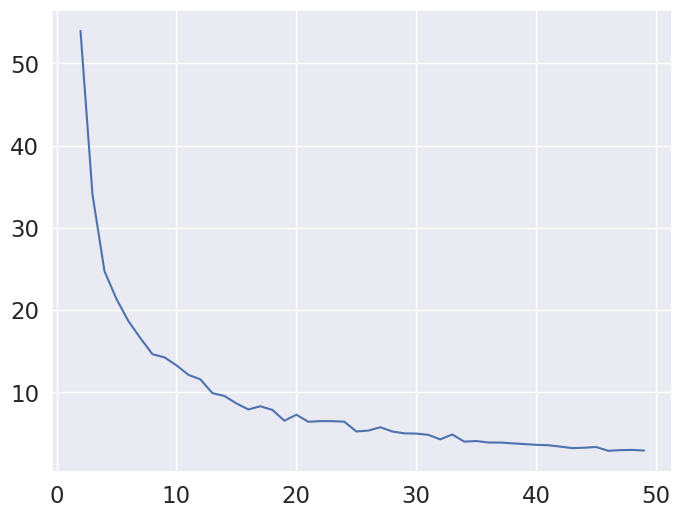

In [ ]:
plt.plot(range(2, 50),msdList)
# plt.legend()

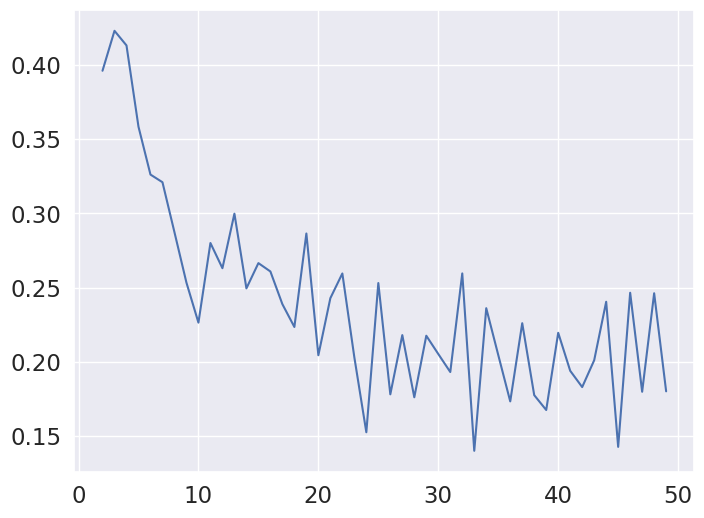

In [ ]:
plt.plot(range(2, 50),ssList)

In [ ]:
ssList

[0.3961670960505321,
 0.42309299036193465,
 0.41323359261533565,
 0.35845788368236225,
 0.3261781234857473,
 0.3210218185677933,
 0.28731660888773275,
 0.253313999920173,
 0.2263632245918344,
 0.2800443974094739,
 0.26306477416604523,
 0.29982583670778495,
 0.24946632458173335,
 0.2664948055996919,
 0.26086196467330064,
 0.2388250543440697,
 0.22344328586449985,
 0.2864523182027193,
 0.20438943745296306,
 0.24285641708041436,
 0.25951011364743903,
 0.2030292936394905,
 0.1524776186314184,
 0.2530605686721461,
 0.17804834649861753,
 0.21797379597922112,
 0.1760364306068806,
 0.2175449619629544,
 0.2052350202032814,
 0.19307598235588874,
 0.25954955883184183,
 0.13996926253115632,
 0.2360961350143296,
 0.20456532329040925,
 0.17327527321976624,
 0.2259775564639099,
 0.17749398788946716,
 0.16747193618039868,
 0.21952097898588666,
 0.19391310866628164,
 0.18292616851943408,
 0.20100552743654487,
 0.24043623686508794,
 0.1426149888103317,
 0.24651006524270347,
 0.1797739614683562,
 0.24617

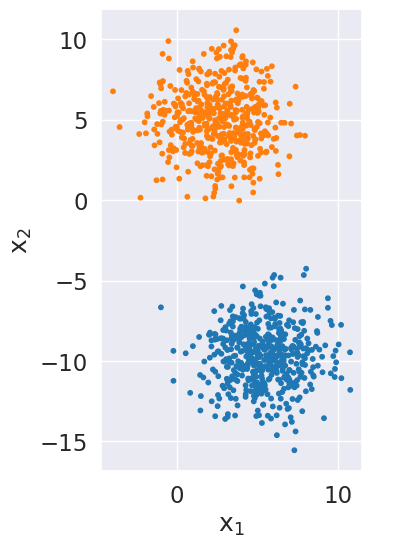

In [ ]:
# first, we generate some data
cluster_std=2
X, y = make_blobs(n_samples=1000, centers=2, cluster_std=cluster_std,
                  n_features=2, random_state=10)

# fit the GMM model
nb_components = 2
GMM = mixture.GaussianMixture(n_components=nb_components,
                              covariance_type='full')
GMM.fit(X)

# Plot the clustering result, where the color of the points indicate
# to which cluster they probabilistically belong to.
super_scat_it(X, GMM.predict_proba(X), dim=nb_components,
              clusters_center=0, task='EM')

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
db = DBSCAN(2, min_samples=1)
db.fit(X)

DBSCAN(eps=2, min_samples=1)

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: >

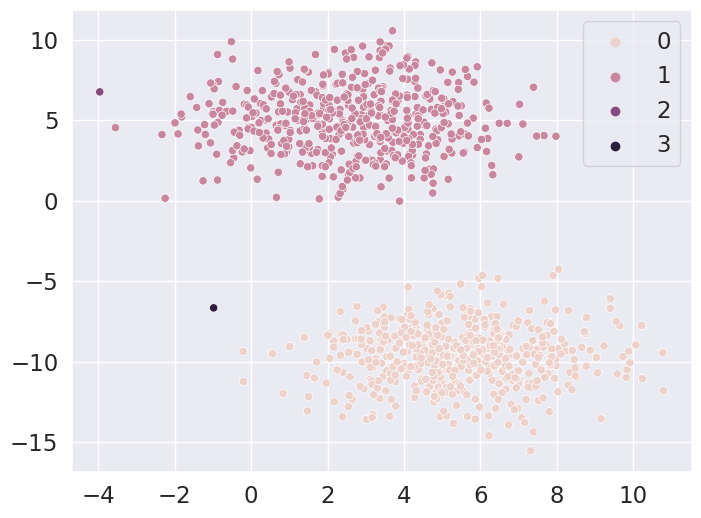

In [ ]:
sns.scatterplot(x= X[:, 0], y= X[:, 1], hue=db.labels_, cmap = 'tab20')

In [ ]:
nb_obs = 10**4  # Number of observations
k = 3           # Number of groups
std = 0.01      # Standard deviation for each blob
dim = 5         # Data dimensions
seed = 10       # Seed to control the data generation

X, y = make_blobs(n_samples=nb_obs, centers=k, cluster_std=std,
                  n_features=dim, random_state=10)   # Data generation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
import warnings # to remove some sklearn warnings
warnings.filterwarnings("ignore")

from sklearn.neural_network import MLPRegressor

learning_rate = 1e-1
aenn = MLPRegressor(hidden_layer_sizes=(2), # a single hidden layer of size 2
             activation='logistic',
             solver='adam',
             alpha=0.0001,
             batch_size='auto',
             early_stopping=True,
             learning_rate_init=learning_rate,
             verbose=True)

# Since we use early_stopping builtin into the MLPRegressor,
# we use both train and validation as our training set.
aenn.fit(np.vstack((X_train, X_valid)), np.vstack((X_train, X_valid)))

Iteration 1, loss = 12.20862840
Validation score: 0.655398
Iteration 2, loss = 4.56986544
Validation score: 0.883360
Iteration 3, loss = 1.81661732
Validation score: 0.957771
Iteration 4, loss = 0.76008199
Validation score: 0.984299
Iteration 5, loss = 0.30783475
Validation score: 0.994155
Iteration 6, loss = 0.11674324
Validation score: 0.997958
Iteration 7, loss = 0.04050203
Validation score: 0.999338
Iteration 8, loss = 0.01293865
Validation score: 0.999804
Iteration 9, loss = 0.00387536
Validation score: 0.999945
Iteration 10, loss = 0.00120254
Validation score: 0.999985
Iteration 11, loss = 0.00049143
Validation score: 0.999994
Iteration 12, loss = 0.00032358
Validation score: 0.999996
Iteration 13, loss = 0.00028811
Validation score: 0.999997
Iteration 14, loss = 0.00028146
Validation score: 0.999997
Iteration 15, loss = 0.00028036
Validation score: 0.999997
Iteration 16, loss = 0.00028027
Validation score: 0.999997
Iteration 17, loss = 0.00028027
Validation score: 0.999997
Itera

MLPRegressor(activation='logistic', early_stopping=True, hidden_layer_sizes=2,
             learning_rate_init=0.1, verbose=True)

In [ ]:
n_sub = 500 # we use a subset of 500 samples from the original data

from scipy.special import expit

X_sub = X_train[0:n_sub]
y_sub = y_train[0:n_sub]

# Get the hidden representations
hiddens = expit(np.dot(X_sub, aenn.coefs_[0]) + aenn.intercepts_[0])
hiddens.shape

(500, 2)

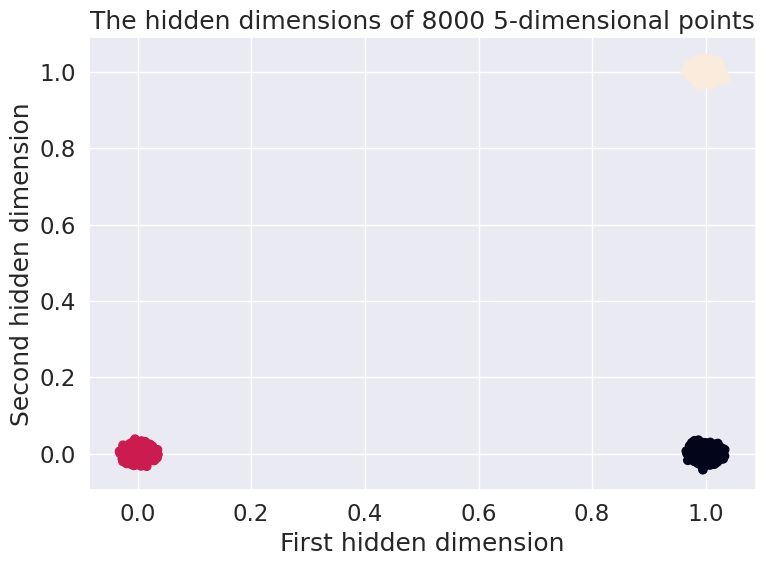

In [ ]:
n_sub = len(X_train) # we use a subset of 500 samples from the original data

from scipy.special import expit

X_sub = X_train[0:n_sub]
y_sub = y_train[0:n_sub]

# Get the hidden representations
hiddens = expit(np.dot(X_sub, aenn.coefs_[0]) + aenn.intercepts_[0])

# Plot
fig = plt.figure()
hiddens += np.random.randn(n_sub,2)*0.01 # add a bit of noise for vizualization purposes
plt.scatter(hiddens[:, 1], hiddens[:, 0], c=y_sub)
plt.xlabel('First hidden dimension')
plt.ylabel('Second hidden dimension')
plt.title('The hidden dimensions of %d %d-dimensional points' % (X_sub.shape))
plt.tight_layout()